In [1]:
# Frustratingly Easy Domain Adaptation
# cao bin, HKUST, China, binjacobcao@gmail.com
# free to charge for academic communication

import numpy as np
import pandas as pd 

def FEDA_features(source_file, target_file):
    """
    Generate feature-expanded datasets for domain adaptation.
    
    Args:
        source_file (str): Path to the CSV file containing source data.
        target_file (str): Path to the CSV file containing target data.
        
    Returns:
        pd.DataFrame, pd.DataFrame: Feature-expanded datasets for source and target.
    """
    # Read source data from CSV file
    source_data = pd.read_csv(source_file)
    target_data = pd.read_csv(target_file)
    source_header = source_data.columns.tolist()
    target_header = target_data.columns.tolist()
    x_source = np.array(source_data.iloc[:,:-1])
    y_source = np.array(source_data.iloc[:,-1])
    x_target = np.array(target_data.iloc[:,:-1])
    y_target = np.array(target_data.iloc[:,-1])
 
    # Expand features for source and target
    x_source_expand = np.hstack([x_source, x_source, np.zeros_like(x_source)])
    x_target_expand = np.hstack([x_target, np.zeros_like(x_target), x_target])

    # Generate expanded header
    expand_header = []
    for name in source_header[:-1]:
        expand_header.append(name + '_g')
    for name in source_header[:-1]:
        expand_header.append(name + '_s')
    for name in target_header[:-1]:
        expand_header.append(name + '_t')
    
    # Create DataFrames for expanded data
    data_source_expand = pd.DataFrame(x_source_expand, columns=expand_header)
    data_target_expand = pd.DataFrame(x_target_expand, columns=expand_header)

    # Add labels to the DataFrames
    data_source_expand[source_header[-1]] = np.array(y_source)
    data_target_expand[target_header[-1]] = np.array(y_target)

    return data_source_expand, data_target_expand


# define NN model

In [2]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Flatten

"""
define the structure of NN

in our case, input feature is 1-d and out put response is also 1-d
"""
class FEDA_NN(Model):
    def __init__(self):
        super(FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

# generate dataset

In [3]:
from sklearn.model_selection import train_test_split

ds, dt = FEDA_features(source_file='source.csv', target_file='target.csv')
    
x_source = np.array(ds.iloc[:,:-1])
y_source = np.array(ds.iloc[:,-1])
x_target = np.array(dt.iloc[:,:-1])
y_target = np.array(dt.iloc[:,-1])

testdata = pd.read_csv('test.csv')
x_test = np.array(testdata.iloc[:,:-1])
y_test = np.array(testdata.iloc[:,-1])

S_x_train, S_x_val, S_y_train, S_y_val = train_test_split(x_source, y_source, test_size=0.3, random_state=42)
S_x_train = tf.convert_to_tensor(S_x_train, dtype=tf.float32)
S_y_train = tf.convert_to_tensor(S_y_train, dtype=tf.float32)
S_x_val = tf.convert_to_tensor(S_x_val, dtype=tf.float32)
S_y_val = tf.convert_to_tensor(S_y_val, dtype=tf.float32)


T_x_train, T_x_val, T_y_train, T_y_val = train_test_split(x_target, y_target, test_size=0.3, random_state=42)
T_x_train = tf.convert_to_tensor(T_x_train, dtype=tf.float32)
T_y_train = tf.convert_to_tensor(T_y_train, dtype=tf.float32)
T_x_val = tf.convert_to_tensor(T_x_val, dtype=tf.float32)
T_y_val = tf.convert_to_tensor(T_y_val, dtype=tf.float32)

# training on source domain and save the weights

In [4]:
import os
# training on the Feature-expanded source domain data
Smodel = FEDA_NN()

# comolie the model 
Smodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

checkpoint_save_path = "./checkpoint/source_weights.ckpt"
"""
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the param. of source domain-----------------')
    Smodel.load_weights(checkpoint_save_path)

"""
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_source, y_source, test_size=0.3, random_state=42)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

history = Smodel.fit(x_train, y_train, batch_size=3, epochs=300,validation_data=(x_val, y_val), validation_freq=1,
                    callbacks=[cp_callback])
Smodel.summary()

Epoch 1/300
4/4 [==============================] - 0s 26ms/step - loss: 1353.7758 - mse: 1353.7758 - val_loss: 1261.5439 - val_mse: 1261.5439
Epoch 2/300
4/4 [==============================] - 0s 6ms/step - loss: 1351.5378 - mse: 1351.5378 - val_loss: 1259.4016 - val_mse: 1259.4016
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 1349.3020 - mse: 1349.3020 - val_loss: 1257.2711 - val_mse: 1257.2711
Epoch 4/300
4/4 [==============================] - 0s 5ms/step - loss: 1347.1222 - mse: 1347.1222 - val_loss: 1255.1423 - val_mse: 1255.1423
Epoch 5/300
4/4 [==============================] - 0s 6ms/step - loss: 1344.8984 - mse: 1344.8984 - val_loss: 1253.0294 - val_mse: 1253.0294
Epoch 6/300
4/4 [==============================] - 0s 5ms/step - loss: 1342.7402 - mse: 1342.7402 - val_loss: 1250.9202 - val_mse: 1250.9202
Epoch 7/300
4/4 [==============================] - 0s 6ms/step - loss: 1340.5226 - mse: 1340.5226 - val_loss: 1248.8287 - val_mse: 1248.8287
Epoch 8/300


Epoch 59/300
4/4 [==============================] - 0s 5ms/step - loss: 1170.6372 - mse: 1170.6372 - val_loss: 1082.6003 - val_mse: 1082.6003
Epoch 60/300
4/4 [==============================] - 0s 5ms/step - loss: 1164.7446 - mse: 1164.7446 - val_loss: 1076.7637 - val_mse: 1076.7637
Epoch 61/300
4/4 [==============================] - 0s 5ms/step - loss: 1158.5757 - mse: 1158.5757 - val_loss: 1070.7965 - val_mse: 1070.7965
Epoch 62/300
4/4 [==============================] - 0s 5ms/step - loss: 1152.3356 - mse: 1152.3357 - val_loss: 1064.6565 - val_mse: 1064.6565
Epoch 63/300
4/4 [==============================] - 0s 5ms/step - loss: 1145.9028 - mse: 1145.9027 - val_loss: 1058.3531 - val_mse: 1058.3531
Epoch 64/300
4/4 [==============================] - 0s 5ms/step - loss: 1139.3451 - mse: 1139.3451 - val_loss: 1051.8474 - val_mse: 1051.8474
Epoch 65/300
4/4 [==============================] - 0s 5ms/step - loss: 1132.5100 - mse: 1132.5100 - val_loss: 1045.2126 - val_mse: 1045.2126
Epoch 

Epoch 118/300
4/4 [==============================] - 0s 5ms/step - loss: 573.9961 - mse: 573.9961 - val_loss: 506.8017 - val_mse: 506.8017
Epoch 119/300
4/4 [==============================] - 0s 5ms/step - loss: 561.4788 - mse: 561.4788 - val_loss: 494.9960 - val_mse: 494.9960
Epoch 120/300
4/4 [==============================] - 0s 5ms/step - loss: 549.1256 - mse: 549.1256 - val_loss: 483.3383 - val_mse: 483.3383
Epoch 121/300
4/4 [==============================] - 0s 5ms/step - loss: 536.7076 - mse: 536.7076 - val_loss: 471.7756 - val_mse: 471.7756
Epoch 122/300
4/4 [==============================] - 0s 5ms/step - loss: 524.4640 - mse: 524.4640 - val_loss: 460.2298 - val_mse: 460.2298
Epoch 123/300
4/4 [==============================] - 0s 5ms/step - loss: 512.3531 - mse: 512.3531 - val_loss: 448.7077 - val_mse: 448.7077
Epoch 124/300
4/4 [==============================] - 0s 5ms/step - loss: 500.1173 - mse: 500.1173 - val_loss: 437.3083 - val_mse: 437.3083
Epoch 125/300
4/4 [========

4/4 [==============================] - 0s 5ms/step - loss: 63.7955 - mse: 63.7955 - val_loss: 40.8422 - val_mse: 40.8422
Epoch 178/300
4/4 [==============================] - 0s 5ms/step - loss: 60.3380 - mse: 60.3380 - val_loss: 38.0952 - val_mse: 38.0952
Epoch 179/300
4/4 [==============================] - 0s 5ms/step - loss: 57.2122 - mse: 57.2122 - val_loss: 35.3979 - val_mse: 35.3979
Epoch 180/300
4/4 [==============================] - 0s 5ms/step - loss: 53.9396 - mse: 53.9396 - val_loss: 32.8897 - val_mse: 32.8897
Epoch 181/300
4/4 [==============================] - 0s 5ms/step - loss: 51.0628 - mse: 51.0628 - val_loss: 30.4946 - val_mse: 30.4946
Epoch 182/300
4/4 [==============================] - 0s 5ms/step - loss: 48.2369 - mse: 48.2369 - val_loss: 28.2816 - val_mse: 28.2816
Epoch 183/300
4/4 [==============================] - 0s 5ms/step - loss: 45.6459 - mse: 45.6459 - val_loss: 26.1894 - val_mse: 26.1894
Epoch 184/300
4/4 [==============================] - 0s 5ms/step - lo

Epoch 239/300
4/4 [==============================] - 0s 4ms/step - loss: 6.3358 - mse: 6.3358 - val_loss: 1.1099 - val_mse: 1.1099
Epoch 240/300
4/4 [==============================] - 0s 4ms/step - loss: 6.3043 - mse: 6.3043 - val_loss: 1.1407 - val_mse: 1.1407
Epoch 241/300
4/4 [==============================] - 0s 3ms/step - loss: 6.2739 - mse: 6.2739 - val_loss: 1.1725 - val_mse: 1.1725
Epoch 242/300
4/4 [==============================] - 0s 4ms/step - loss: 6.2486 - mse: 6.2486 - val_loss: 1.2082 - val_mse: 1.2082
Epoch 243/300
4/4 [==============================] - 0s 3ms/step - loss: 6.2254 - mse: 6.2254 - val_loss: 1.2461 - val_mse: 1.2461
Epoch 244/300
4/4 [==============================] - 0s 3ms/step - loss: 6.1841 - mse: 6.1841 - val_loss: 1.2630 - val_mse: 1.2630
Epoch 245/300
4/4 [==============================] - 0s 4ms/step - loss: 6.1741 - mse: 6.1741 - val_loss: 1.2823 - val_mse: 1.2823
Epoch 246/300
4/4 [==============================] - 0s 4ms/step - loss: 6.1599 - m

 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  16        
                                                                 
 dense_1 (Dense)             multiple                  15        
                                                                 
 dense_2 (Dense)             multiple                  4         
                                                                 
Total params: 35 (140.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Smodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 47ms/step
[[32.866447]
 [32.545837]]
Root Mean Squared Error: 5.114044384675083


# plot the loss

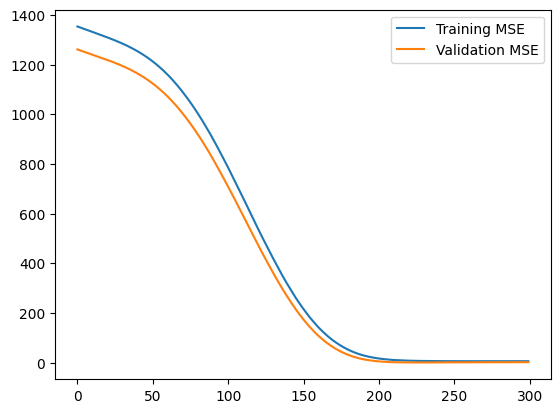

In [7]:
from matplotlib import pyplot as plt

mse_S = history.history['mse']
val_mse_S = history.history['val_mse']
loss_S = history.history['loss']
val_loss_S =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_S,label='Training MSE')
plt.plot(val_mse_S,label='Validation MSE')
plt.legend()
plt.savefig('Sdomain_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Sdomain_loss.svg',bbox_inches = 'tight',dpi=600)

# transfer to target domain

## define L2 Loss :

In [8]:

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of source domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of source domain-----------------
Layer: dense
[array([[-1.4991595 ,  2.6635475 ,  1.0278542 , -1.7998044 ],
       [-1.8269482 ,  1.1425062 ,  3.1675317 ,  0.16922665],
       [ 0.10313631,  0.7004749 ,  0.8891627 , -0.15022126]],
      dtype=float32), array([-1.1099403 ,  1.0126255 ,  0.87590355, -0.8496216 ], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[-1.2130995 , -1.541604  , -1.1141932 ],
       [ 2.7016797 ,  1.9198126 ,  0.5121494 ],
       [ 1.2966318 ,  3.77212   ,  0.09696086],
       [-0.8903979 ,  1.531695  , -2.9293997 ]], dtype=float32), array([0.7908309, 1.0010245, 0.7351754], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[1.3971769],
       [1.0204301],
       [1.6852666]], dtype=float32), array([0.5939082], dtype=float32)]
--------------------------------------------------


In [9]:
class KernelRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, initial_weights, l2_factor):
        self.initial_weights = initial_weights
        self.l2_factor = l2_factor
    
    def __call__(self, weights):
        initial_weights_flat = tf.reshape(tf.convert_to_tensor(self.initial_weights), shape=(-1,))
        weights_flat = tf.reshape(weights, shape=(-1,))
        regularization = tf.reduce_sum(tf.square(weights_flat - initial_weights_flat))
        l2_regularization = self.l2_factor * tf.reduce_sum(tf.square(weights))
        return regularization + l2_regularization
    
    def get_config(self):
        return {'initial_weights': self.initial_weights, 'l2_factor': self.l2_factor}


## define model on target domain :

In [10]:

# Adjust the strength of L2 regularization as needed
l2_reg_factor = 0.1  


class Transfer_FEDA_NN(Model):
    def __init__(self):
        super(Transfer_FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=0.01))
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=0.01))
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=0.01))
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y



In [14]:
# Create the model
Tmodel = Transfer_FEDA_NN()

Tmodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'],
             )


checkpoint_save_path = "./checkpoint/target_weights.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Train the model
Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])

# Print model summary
Tmodel.summary()

Epoch 1/900
1/1 [==============================] - 0s 219ms/step - loss: 1858.4861 - mse: 1774.1968 - val_loss: 1367.8035 - val_mse: 1283.5280
Epoch 2/900
1/1 [==============================] - 0s 16ms/step - loss: 1857.0729 - mse: 1772.7974 - val_loss: 1366.6373 - val_mse: 1282.3756
Epoch 3/900
1/1 [==============================] - 0s 17ms/step - loss: 1855.6606 - mse: 1771.3989 - val_loss: 1365.4720 - val_mse: 1281.2242
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1854.2490 - mse: 1770.0012 - val_loss: 1364.3079 - val_mse: 1280.0737
Epoch 5/900
1/1 [==============================] - 0s 17ms/step - loss: 1852.8386 - mse: 1768.6045 - val_loss: 1363.1444 - val_mse: 1278.9237
Epoch 6/900
1/1 [==============================] - 0s 17ms/step - loss: 1851.4294 - mse: 1767.2087 - val_loss: 1361.9821 - val_mse: 1277.7748
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1850.0211 - mse: 1765.8138 - val_loss: 1360.8203 - val_mse: 1276.6263
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 1778.8486 - mse: 1694.9454 - val_loss: 1302.1964 - val_mse: 1218.2932
Epoch 59/900
1/1 [==============================] - 0s 23ms/step - loss: 1777.4415 - mse: 1693.5383 - val_loss: 1301.0380 - val_mse: 1217.1345
Epoch 60/900
1/1 [==============================] - 0s 17ms/step - loss: 1776.0333 - mse: 1692.1299 - val_loss: 1299.8783 - val_mse: 1215.9742
Epoch 61/900
1/1 [==============================] - 0s 16ms/step - loss: 1774.6234 - mse: 1690.7194 - val_loss: 1298.7173 - val_mse: 1214.8127
Epoch 62/900
1/1 [==============================] - 0s 16ms/step - loss: 1773.2115 - mse: 1689.3070 - val_loss: 1297.5552 - val_mse: 1213.6497
Epoch 63/900
1/1 [==============================] - 0s 15ms/step - loss: 1771.7983 - mse: 1687.8928 - val_loss: 1296.3912 - val_mse: 1212.4847
Epoch 64/900
1/1 [==============================] - 0s 16ms/step - loss: 1770.3829 - mse: 1686.4764 - val_loss: 1295.2260 - val_mse: 1211.3182
Epoch 65/900

1/1 [==============================] - 0s 15ms/step - loss: 1694.5735 - mse: 1610.1965 - val_loss: 1232.8541 - val_mse: 1148.4579
Epoch 116/900
1/1 [==============================] - 0s 15ms/step - loss: 1692.9929 - mse: 1608.5967 - val_loss: 1231.5549 - val_mse: 1147.1392
Epoch 117/900
1/1 [==============================] - 0s 15ms/step - loss: 1691.4075 - mse: 1606.9917 - val_loss: 1230.2527 - val_mse: 1145.8168
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1689.8181 - mse: 1605.3822 - val_loss: 1228.9464 - val_mse: 1144.4900
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1688.2238 - mse: 1603.7673 - val_loss: 1227.6370 - val_mse: 1143.1593
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1686.6252 - mse: 1602.1477 - val_loss: 1226.3232 - val_mse: 1141.8245
Epoch 121/900
1/1 [==============================] - 0s 16ms/step - loss: 1685.0216 - mse: 1600.5228 - val_loss: 1225.0065 - val_mse: 1140.4856
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1596.2388 - mse: 1510.1348 - val_loss: 1152.2213 - val_mse: 1066.0771
Epoch 173/900
1/1 [==============================] - 0s 16ms/step - loss: 1594.3462 - mse: 1508.2020 - val_loss: 1150.6727 - val_mse: 1064.4882
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1592.4473 - mse: 1506.2627 - val_loss: 1149.1194 - val_mse: 1062.8942
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1590.5419 - mse: 1504.3167 - val_loss: 1147.5607 - val_mse: 1061.2947
Epoch 176/900
1/1 [==============================] - 0s 15ms/step - loss: 1588.6301 - mse: 1502.3641 - val_loss: 1145.9972 - val_mse: 1059.6899
Epoch 177/900
1/1 [==============================] - 0s 15ms/step - loss: 1586.7120 - mse: 1500.4048 - val_loss: 1144.4286 - val_mse: 1058.0800
Epoch 178/900
1/1 [==============================] - 0s 15ms/step - loss: 1584.7876 - mse: 1498.4390 - val_loss: 1142.8547 - val_mse: 10

1/1 [==============================] - 0s 16ms/step - loss: 1477.8188 - mse: 1389.0874 - val_loss: 1055.6127 - val_mse: 966.8302
Epoch 230/900
1/1 [==============================] - 0s 16ms/step - loss: 1475.5428 - mse: 1386.7605 - val_loss: 1053.7617 - val_mse: 964.9283
Epoch 231/900
1/1 [==============================] - 0s 15ms/step - loss: 1473.2601 - mse: 1384.4268 - val_loss: 1051.9056 - val_mse: 963.0209
Epoch 232/900
1/1 [==============================] - 0s 15ms/step - loss: 1470.9705 - mse: 1382.0857 - val_loss: 1050.0439 - val_mse: 961.1078
Epoch 233/900
1/1 [==============================] - 0s 15ms/step - loss: 1468.6738 - mse: 1379.7378 - val_loss: 1048.1768 - val_mse: 959.1891
Epoch 234/900
1/1 [==============================] - 0s 16ms/step - loss: 1466.3702 - mse: 1377.3826 - val_loss: 1046.3043 - val_mse: 957.2650
Epoch 235/900
1/1 [==============================] - 0s 16ms/step - loss: 1464.0594 - mse: 1375.0201 - val_loss: 1044.4263 - val_mse: 955.3352
Epoch 236/900

1/1 [==============================] - 0s 16ms/step - loss: 1336.8861 - mse: 1245.0563 - val_loss: 941.4808 - val_mse: 849.5934
Epoch 287/900
1/1 [==============================] - 0s 15ms/step - loss: 1334.2107 - mse: 1242.3232 - val_loss: 939.3245 - val_mse: 847.3793
Epoch 288/900
1/1 [==============================] - 0s 16ms/step - loss: 1331.5278 - mse: 1239.5828 - val_loss: 937.1628 - val_mse: 845.1598
Epoch 289/900
1/1 [==============================] - 0s 15ms/step - loss: 1328.8386 - mse: 1236.8357 - val_loss: 934.9960 - val_mse: 842.9351
Epoch 290/900
1/1 [==============================] - 0s 15ms/step - loss: 1326.1422 - mse: 1234.0813 - val_loss: 932.8240 - val_mse: 840.7051
Epoch 291/900
1/1 [==============================] - 0s 15ms/step - loss: 1323.4392 - mse: 1231.3201 - val_loss: 930.6470 - val_mse: 838.4699
Epoch 292/900
1/1 [==============================] - 0s 15ms/step - loss: 1320.7288 - mse: 1228.5518 - val_loss: 928.4650 - val_mse: 836.2296
Epoch 293/900
1/1 [=

Epoch 344/900
1/1 [==============================] - 0s 16ms/step - loss: 1170.6375 - mse: 1075.2928 - val_loss: 808.3583 - val_mse: 712.9501
Epoch 345/900
1/1 [==============================] - 0s 16ms/step - loss: 1167.5834 - mse: 1072.1752 - val_loss: 805.9308 - val_mse: 710.4590
Epoch 346/900
1/1 [==============================] - 0s 16ms/step - loss: 1164.5234 - mse: 1069.0518 - val_loss: 803.4994 - val_mse: 707.9638
Epoch 347/900
1/1 [==============================] - 0s 16ms/step - loss: 1161.4576 - mse: 1065.9220 - val_loss: 801.0641 - val_mse: 705.4647
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1158.3860 - mse: 1062.7865 - val_loss: 798.6249 - val_mse: 702.9614
Epoch 349/900
1/1 [==============================] - 0s 15ms/step - loss: 1155.3085 - mse: 1059.6450 - val_loss: 796.1817 - val_mse: 700.4542
Epoch 350/900
1/1 [==============================] - 0s 16ms/step - loss: 1152.2256 - mse: 1056.4979 - val_loss: 793.7349 - val_mse: 697.9431
Epoch 

Epoch 402/900
1/1 [==============================] - 0s 15ms/step - loss: 984.9629 - mse: 885.7833 - val_loss: 662.2124 - val_mse: 562.9645
Epoch 403/900
1/1 [==============================] - 0s 16ms/step - loss: 981.6364 - mse: 882.3885 - val_loss: 659.6238 - val_mse: 560.3074
Epoch 404/900
1/1 [==============================] - 0s 15ms/step - loss: 978.3070 - mse: 878.9907 - val_loss: 657.0340 - val_mse: 557.6490
Epoch 405/900
1/1 [==============================] - 0s 16ms/step - loss: 974.9747 - mse: 875.5897 - val_loss: 654.4429 - val_mse: 554.9894
Epoch 406/900
1/1 [==============================] - 0s 15ms/step - loss: 971.6393 - mse: 872.1858 - val_loss: 651.8508 - val_mse: 552.3286
Epoch 407/900
1/1 [==============================] - 0s 16ms/step - loss: 968.3010 - mse: 868.7788 - val_loss: 649.2575 - val_mse: 549.6666
Epoch 408/900
1/1 [==============================] - 0s 15ms/step - loss: 964.9599 - mse: 865.3690 - val_loss: 646.6634 - val_mse: 547.0037
Epoch 409/900
1/1 [=

1/1 [==============================] - 0s 16ms/step - loss: 789.2668 - mse: 686.0371 - val_loss: 512.1578 - val_mse: 408.8573
Epoch 461/900
1/1 [==============================] - 0s 16ms/step - loss: 785.8904 - mse: 682.5900 - val_loss: 509.6146 - val_mse: 406.2433
Epoch 462/900
1/1 [==============================] - 0s 16ms/step - loss: 782.5156 - mse: 679.1444 - val_loss: 507.0744 - val_mse: 403.6323
Epoch 463/900
1/1 [==============================] - 0s 15ms/step - loss: 779.1428 - mse: 675.7008 - val_loss: 504.5374 - val_mse: 401.0245
Epoch 464/900
1/1 [==============================] - 0s 16ms/step - loss: 775.7720 - mse: 672.2590 - val_loss: 502.0037 - val_mse: 398.4200
Epoch 465/900
1/1 [==============================] - 0s 16ms/step - loss: 772.4028 - mse: 668.8191 - val_loss: 499.4733 - val_mse: 395.8187
Epoch 466/900
1/1 [==============================] - 0s 15ms/step - loss: 769.0359 - mse: 665.3813 - val_loss: 496.9461 - val_mse: 393.2206
Epoch 467/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 599.1779 - mse: 491.8516 - val_loss: 372.2333 - val_mse: 264.8371
Epoch 519/900
1/1 [==============================] - 0s 16ms/step - loss: 596.0571 - mse: 488.6609 - val_loss: 370.0018 - val_mse: 262.5358
Epoch 520/900
1/1 [==============================] - 0s 16ms/step - loss: 592.9436 - mse: 485.4777 - val_loss: 367.7778 - val_mse: 260.2421
Epoch 521/900
1/1 [==============================] - 0s 16ms/step - loss: 589.8372 - mse: 482.3014 - val_loss: 365.5616 - val_mse: 257.9562
Epoch 522/900
1/1 [==============================] - 0s 15ms/step - loss: 586.7381 - mse: 479.1327 - val_loss: 363.3532 - val_mse: 255.6782
Epoch 523/900
1/1 [==============================] - 0s 15ms/step - loss: 583.6465 - mse: 475.9716 - val_loss: 361.1527 - val_mse: 253.4081
Epoch 524/900
1/1 [==============================] - 0s 16ms/step - loss: 580.5624 - mse: 472.8178 - val_loss: 358.9601 - val_mse: 251.1460
Epoch 525/900
1/1 [===============

1/1 [==============================] - 0s 16ms/step - loss: 432.5685 - mse: 321.3156 - val_loss: 257.4421 - val_mse: 146.1245
Epoch 577/900
1/1 [==============================] - 0s 16ms/step - loss: 429.9953 - mse: 318.6776 - val_loss: 255.7556 - val_mse: 144.3733
Epoch 578/900
1/1 [==============================] - 0s 16ms/step - loss: 427.4333 - mse: 316.0511 - val_loss: 254.0797 - val_mse: 142.6329
Epoch 579/900
1/1 [==============================] - 0s 15ms/step - loss: 424.8829 - mse: 313.4362 - val_loss: 252.4147 - val_mse: 140.9036
Epoch 580/900
1/1 [==============================] - 0s 15ms/step - loss: 422.3440 - mse: 310.8329 - val_loss: 250.7606 - val_mse: 139.1853
Epoch 581/900
1/1 [==============================] - 0s 16ms/step - loss: 419.8167 - mse: 308.2414 - val_loss: 249.1173 - val_mse: 137.4779
Epoch 582/900
1/1 [==============================] - 0s 15ms/step - loss: 417.3010 - mse: 305.6616 - val_loss: 247.4850 - val_mse: 135.7816
Epoch 583/900
1/1 [===============

Epoch 635/900
1/1 [==============================] - 0s 16ms/step - loss: 301.5566 - mse: 186.7458 - val_loss: 177.0127 - val_mse: 62.1470
Epoch 636/900
1/1 [==============================] - 0s 15ms/step - loss: 299.7156 - mse: 184.8500 - val_loss: 175.9871 - val_mse: 61.0667
Epoch 637/900
1/1 [==============================] - 0s 16ms/step - loss: 297.8875 - mse: 182.9672 - val_loss: 174.9725 - val_mse: 59.9976
Epoch 638/900
1/1 [==============================] - 0s 15ms/step - loss: 296.0723 - mse: 181.0974 - val_loss: 173.9689 - val_mse: 58.9398
Epoch 639/900
1/1 [==============================] - 0s 15ms/step - loss: 294.2700 - mse: 179.2408 - val_loss: 172.9763 - val_mse: 57.8931
Epoch 640/900
1/1 [==============================] - 0s 15ms/step - loss: 292.4805 - mse: 177.3972 - val_loss: 171.9948 - val_mse: 56.8577
Epoch 641/900
1/1 [==============================] - 0s 15ms/step - loss: 290.7038 - mse: 175.5667 - val_loss: 171.0243 - val_mse: 55.8335
Epoch 642/900
1/1 [========

Epoch 694/900
1/1 [==============================] - 0s 16ms/step - loss: 214.3311 - mse: 96.6682 - val_loss: 134.2907 - val_mse: 16.5868
Epoch 695/900
1/1 [==============================] - 0s 16ms/step - loss: 213.2093 - mse: 95.5054 - val_loss: 133.8515 - val_mse: 16.1069
Epoch 696/900
1/1 [==============================] - 0s 15ms/step - loss: 212.0984 - mse: 94.3539 - val_loss: 133.4207 - val_mse: 15.6356
Epoch 697/900
1/1 [==============================] - 0s 15ms/step - loss: 210.9986 - mse: 93.2136 - val_loss: 132.9981 - val_mse: 15.1730
Epoch 698/900
1/1 [==============================] - 0s 16ms/step - loss: 209.9096 - mse: 92.0844 - val_loss: 132.5838 - val_mse: 14.7188
Epoch 699/900
1/1 [==============================] - 0s 15ms/step - loss: 208.8315 - mse: 90.9664 - val_loss: 132.1777 - val_mse: 14.2731
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 207.7641 - mse: 89.8594 - val_loss: 131.7797 - val_mse: 13.8357
Epoch 701/900
1/1 [===============

Epoch 754/900
1/1 [==============================] - 0s 16ms/step - loss: 164.4730 - mse: 44.8353 - val_loss: 120.4695 - val_mse: 0.8074
Epoch 755/900
1/1 [==============================] - 0s 15ms/step - loss: 163.9038 - mse: 44.2417 - val_loss: 120.4134 - val_mse: 0.7272
Epoch 756/900
1/1 [==============================] - 0s 15ms/step - loss: 163.3418 - mse: 43.6557 - val_loss: 120.3616 - val_mse: 0.6515
Epoch 757/900
1/1 [==============================] - 0s 15ms/step - loss: 162.7871 - mse: 43.0770 - val_loss: 120.3141 - val_mse: 0.5804
Epoch 758/900
1/1 [==============================] - 0s 15ms/step - loss: 162.2394 - mse: 42.5057 - val_loss: 120.2707 - val_mse: 0.5137
Epoch 759/900
1/1 [==============================] - 0s 15ms/step - loss: 161.6987 - mse: 41.9416 - val_loss: 120.2315 - val_mse: 0.4514
Epoch 760/900
1/1 [==============================] - 0s 16ms/step - loss: 161.1649 - mse: 41.3849 - val_loss: 120.1963 - val_mse: 0.3934
Epoch 761/900
1/1 [======================

Epoch 814/900
1/1 [==============================] - 0s 11ms/step - loss: 140.9079 - mse: 20.2844 - val_loss: 122.6675 - val_mse: 2.0354
Epoch 815/900
1/1 [==============================] - 0s 11ms/step - loss: 140.6611 - mse: 20.0291 - val_loss: 122.7669 - val_mse: 2.1267
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 140.4178 - mse: 19.7775 - val_loss: 122.8675 - val_mse: 2.2192
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 140.1782 - mse: 19.5299 - val_loss: 122.9691 - val_mse: 2.3130
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 139.9420 - mse: 19.2859 - val_loss: 123.0717 - val_mse: 2.4081
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 139.7094 - mse: 19.0458 - val_loss: 123.1753 - val_mse: 2.5044
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 139.4802 - mse: 18.8093 - val_loss: 123.2798 - val_mse: 2.6019
Epoch 821/900
1/1 [======================

Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 131.0850 - mse: 10.3503 - val_loss: 129.4565 - val_mse: 8.7261
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 130.9850 - mse: 10.2546 - val_loss: 129.5683 - val_mse: 8.8425
Epoch 876/900
1/1 [==============================] - 0s 11ms/step - loss: 130.8863 - mse: 10.1605 - val_loss: 129.6797 - val_mse: 8.9586
Epoch 877/900
1/1 [==============================] - 0s 10ms/step - loss: 130.7891 - mse: 10.0680 - val_loss: 129.7906 - val_mse: 9.0745
Epoch 878/900
1/1 [==============================] - 0s 11ms/step - loss: 130.6934 - mse: 9.9772 - val_loss: 129.9012 - val_mse: 9.1901
Epoch 879/900
1/1 [==============================] - 0s 11ms/step - loss: 130.5990 - mse: 9.8879 - val_loss: 130.0112 - val_mse: 9.3054
Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 130.5059 - mse: 9.8000 - val_loss: 130.1208 - val_mse: 9.4204
Epoch 881/900
1/1 [=========================

In [15]:
checkpoint_save_path = "./checkpoint/target_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[-2.4419835 ,  1.0452218 ,  0.03550817, -1.0983334 ],
       [-0.5895215 , -0.41218024,  1.2093245 ,  0.16136958],
       [-1.8732526 ,  2.07237   , -0.9945138 , -2.2563884 ]],
      dtype=float32), array([-0.9715973 ,  0.5125024 , -0.74442214, -0.9069544 ], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.0340223 ,  1.9490347 , -0.10054011],
       [-1.509545  , -1.4946944 ,  0.9983297 ],
       [ 0.20673124,  2.0077188 ,  2.5072706 ],
       [ 1.8774416 ,  1.1954017 ,  0.36315027]], dtype=float32), array([-0.6684077 , -0.65233576, -0.57671916], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[-1.9879953],
       [-2.2959893],
       [-1.7467483]], dtype=float32), array([0.5723585], dtype=float32)]
--------------------------------------------------


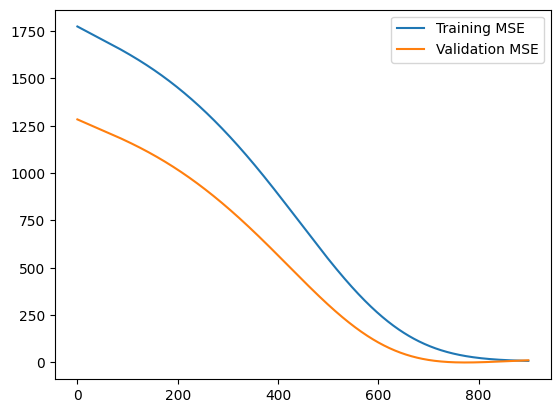

In [16]:
from matplotlib import pyplot as plt

mse_T = Transfer_history.history['mse']
val_mse_T = Transfer_history.history['val_mse']
loss_T = Transfer_history.history['loss']
val_loss_T =  Transfer_history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_T,label='Training MSE')
plt.plot(val_mse_T,label='Validation MSE')
plt.legend()
plt.savefig('Tdomain_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Tdomain_loss.svg',bbox_inches = 'tight',dpi=600)

In [17]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Tmodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 61ms/step
[[39.996243]
 [39.486282]]
Root Mean Squared Error: 3.044639338348102


# compare to a base-line model

In [18]:

class base_NN(Model):
    def __init__(self):
        super(base_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

In [20]:
# train the model on target domain data directly and test on test data
model = base_NN()

# comolie the model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

checkpoint_save_path = "./checkpoint/base_weights.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])
model.summary()

Epoch 1/900
1/1 [==============================] - 0s 164ms/step - loss: 1724.0786 - mse: 1724.0786 - val_loss: 1245.0331 - val_mse: 1245.0331
Epoch 2/900
1/1 [==============================] - 0s 15ms/step - loss: 1723.4272 - mse: 1723.4272 - val_loss: 1244.4867 - val_mse: 1244.4867
Epoch 3/900
1/1 [==============================] - 0s 16ms/step - loss: 1722.7737 - mse: 1722.7737 - val_loss: 1243.9385 - val_mse: 1243.9385
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1722.1180 - mse: 1722.1180 - val_loss: 1243.3881 - val_mse: 1243.3881
Epoch 5/900
1/1 [==============================] - 0s 16ms/step - loss: 1721.4598 - mse: 1721.4598 - val_loss: 1242.8352 - val_mse: 1242.8352
Epoch 6/900
1/1 [==============================] - 0s 16ms/step - loss: 1720.7988 - mse: 1720.7988 - val_loss: 1242.2804 - val_mse: 1242.2804
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1720.1353 - mse: 1720.1353 - val_loss: 1241.7233 - val_mse: 1241.7233
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 1680.1315 - mse: 1680.1315 - val_loss: 1208.0835 - val_mse: 1208.0835
Epoch 59/900
1/1 [==============================] - 0s 16ms/step - loss: 1679.1901 - mse: 1679.1901 - val_loss: 1207.2924 - val_mse: 1207.2924
Epoch 60/900
1/1 [==============================] - 0s 16ms/step - loss: 1678.2412 - mse: 1678.2412 - val_loss: 1206.4951 - val_mse: 1206.4951
Epoch 61/900
1/1 [==============================] - 0s 16ms/step - loss: 1677.2853 - mse: 1677.2853 - val_loss: 1205.6918 - val_mse: 1205.6918
Epoch 62/900
1/1 [==============================] - 0s 16ms/step - loss: 1676.3221 - mse: 1676.3221 - val_loss: 1204.8826 - val_mse: 1204.8826
Epoch 63/900
1/1 [==============================] - 0s 16ms/step - loss: 1675.3517 - mse: 1675.3517 - val_loss: 1204.0673 - val_mse: 1204.0673
Epoch 64/900
1/1 [==============================] - 0s 16ms/step - loss: 1674.3740 - mse: 1674.3740 - val_loss: 1203.2457 - val_mse: 1203.2457
Epoch 65/900

1/1 [==============================] - 0s 16ms/step - loss: 1613.7529 - mse: 1613.7529 - val_loss: 1152.4178 - val_mse: 1152.4178
Epoch 116/900
1/1 [==============================] - 0s 16ms/step - loss: 1612.3347 - mse: 1612.3347 - val_loss: 1151.2310 - val_mse: 1151.2310
Epoch 117/900
1/1 [==============================] - 0s 16ms/step - loss: 1610.9067 - mse: 1610.9067 - val_loss: 1150.0364 - val_mse: 1150.0364
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1609.4695 - mse: 1609.4695 - val_loss: 1148.8339 - val_mse: 1148.8339
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1608.0225 - mse: 1608.0225 - val_loss: 1147.6234 - val_mse: 1147.6234
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1606.5660 - mse: 1606.5660 - val_loss: 1146.4052 - val_mse: 1146.4052
Epoch 121/900
1/1 [==============================] - 0s 15ms/step - loss: 1605.1000 - mse: 1605.1000 - val_loss: 1145.1790 - val_mse: 1145.1790
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1516.9044 - mse: 1516.9044 - val_loss: 1071.6277 - val_mse: 1071.6277
Epoch 173/900
1/1 [==============================] - 0s 15ms/step - loss: 1514.9012 - mse: 1514.9012 - val_loss: 1069.9620 - val_mse: 1069.9620
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1512.8870 - mse: 1512.8870 - val_loss: 1068.2874 - val_mse: 1068.2874
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1510.8619 - mse: 1510.8619 - val_loss: 1066.6039 - val_mse: 1066.6039
Epoch 176/900
1/1 [==============================] - 0s 16ms/step - loss: 1508.8259 - mse: 1508.8259 - val_loss: 1064.9114 - val_mse: 1064.9114
Epoch 177/900
1/1 [==============================] - 0s 16ms/step - loss: 1506.7788 - mse: 1506.7788 - val_loss: 1063.2103 - val_mse: 1063.2103
Epoch 178/900
1/1 [==============================] - 0s 16ms/step - loss: 1504.7209 - mse: 1504.7209 - val_loss: 1061.5005 - val_mse: 10

1/1 [==============================] - 0s 15ms/step - loss: 1385.1663 - mse: 1385.1663 - val_loss: 962.5604 - val_mse: 962.5604
Epoch 230/900
1/1 [==============================] - 0s 15ms/step - loss: 1382.5364 - mse: 1382.5364 - val_loss: 960.3932 - val_mse: 960.3932
Epoch 231/900
1/1 [==============================] - 0s 15ms/step - loss: 1379.8953 - mse: 1379.8953 - val_loss: 958.2173 - val_mse: 958.2173
Epoch 232/900
1/1 [==============================] - 0s 16ms/step - loss: 1377.2434 - mse: 1377.2434 - val_loss: 956.0328 - val_mse: 956.0328
Epoch 233/900
1/1 [==============================] - 0s 16ms/step - loss: 1374.5809 - mse: 1374.5809 - val_loss: 953.8400 - val_mse: 953.8400
Epoch 234/900
1/1 [==============================] - 0s 16ms/step - loss: 1371.9077 - mse: 1371.9077 - val_loss: 951.6386 - val_mse: 951.6386
Epoch 235/900
1/1 [==============================] - 0s 15ms/step - loss: 1369.2235 - mse: 1369.2235 - val_loss: 949.4288 - val_mse: 949.4288
Epoch 236/900
1/1 [=

Epoch 287/900
1/1 [==============================] - 0s 15ms/step - loss: 1215.4147 - mse: 1215.4147 - val_loss: 823.5555 - val_mse: 823.5555
Epoch 288/900
1/1 [==============================] - 0s 16ms/step - loss: 1212.1992 - mse: 1212.1992 - val_loss: 820.9406 - val_mse: 820.9406
Epoch 289/900
1/1 [==============================] - 0s 15ms/step - loss: 1208.9746 - mse: 1208.9746 - val_loss: 818.3190 - val_mse: 818.3190
Epoch 290/900
1/1 [==============================] - 0s 15ms/step - loss: 1205.7410 - mse: 1205.7410 - val_loss: 815.6911 - val_mse: 815.6911
Epoch 291/900
1/1 [==============================] - 0s 15ms/step - loss: 1202.4988 - mse: 1202.4988 - val_loss: 813.0565 - val_mse: 813.0565
Epoch 292/900
1/1 [==============================] - 0s 16ms/step - loss: 1199.2477 - mse: 1199.2477 - val_loss: 810.4155 - val_mse: 810.4155
Epoch 293/900
1/1 [==============================] - 0s 15ms/step - loss: 1195.9877 - mse: 1195.9877 - val_loss: 807.7683 - val_mse: 807.7683
Epoch 

Epoch 345/900
1/1 [==============================] - 0s 15ms/step - loss: 1015.8777 - mse: 1015.8777 - val_loss: 662.7643 - val_mse: 662.7643
Epoch 346/900
1/1 [==============================] - 0s 15ms/step - loss: 1012.2429 - mse: 1012.2429 - val_loss: 659.8655 - val_mse: 659.8655
Epoch 347/900
1/1 [==============================] - 0s 15ms/step - loss: 1008.6030 - mse: 1008.6030 - val_loss: 656.9638 - val_mse: 656.9638
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1004.9581 - mse: 1004.9581 - val_loss: 654.0593 - val_mse: 654.0593
Epoch 349/900
1/1 [==============================] - 0s 15ms/step - loss: 1001.3083 - mse: 1001.3083 - val_loss: 651.1520 - val_mse: 651.1520
Epoch 350/900
1/1 [==============================] - 0s 15ms/step - loss: 997.6537 - mse: 997.6537 - val_loss: 648.2421 - val_mse: 648.2421
Epoch 351/900
1/1 [==============================] - 0s 14ms/step - loss: 993.9943 - mse: 993.9943 - val_loss: 645.3298 - val_mse: 645.3298
Epoch 352/

1/1 [==============================] - 0s 15ms/step - loss: 799.4006 - mse: 799.4006 - val_loss: 492.4090 - val_mse: 492.4090
Epoch 404/900
1/1 [==============================] - 0s 15ms/step - loss: 795.6215 - mse: 795.6215 - val_loss: 489.4815 - val_mse: 489.4815
Epoch 405/900
1/1 [==============================] - 0s 16ms/step - loss: 791.8428 - mse: 791.8428 - val_loss: 486.5562 - val_mse: 486.5562
Epoch 406/900
1/1 [==============================] - 0s 15ms/step - loss: 788.0646 - mse: 788.0646 - val_loss: 483.6330 - val_mse: 483.6330
Epoch 407/900
1/1 [==============================] - 0s 15ms/step - loss: 784.2870 - mse: 784.2870 - val_loss: 480.7121 - val_mse: 480.7121
Epoch 408/900
1/1 [==============================] - 0s 15ms/step - loss: 780.5101 - mse: 780.5101 - val_loss: 477.7936 - val_mse: 477.7936
Epoch 409/900
1/1 [==============================] - 0s 15ms/step - loss: 776.7343 - mse: 776.7343 - val_loss: 474.8776 - val_mse: 474.8776
Epoch 410/900
1/1 [===============

1/1 [==============================] - 0s 16ms/step - loss: 584.1605 - mse: 584.1605 - val_loss: 328.9877 - val_mse: 328.9877
Epoch 462/900
1/1 [==============================] - 0s 16ms/step - loss: 580.5804 - mse: 580.5804 - val_loss: 326.3359 - val_mse: 326.3359
Epoch 463/900
1/1 [==============================] - 0s 15ms/step - loss: 577.0067 - mse: 577.0067 - val_loss: 323.6916 - val_mse: 323.6916
Epoch 464/900
1/1 [==============================] - 0s 15ms/step - loss: 573.4395 - mse: 573.4395 - val_loss: 321.0549 - val_mse: 321.0549
Epoch 465/900
1/1 [==============================] - 0s 15ms/step - loss: 569.8793 - mse: 569.8793 - val_loss: 318.4255 - val_mse: 318.4255
Epoch 466/900
1/1 [==============================] - 0s 15ms/step - loss: 566.3257 - mse: 566.3257 - val_loss: 315.8040 - val_mse: 315.8040
Epoch 467/900
1/1 [==============================] - 0s 15ms/step - loss: 562.7792 - mse: 562.7792 - val_loss: 313.1901 - val_mse: 313.1901
Epoch 468/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 390.2602 - mse: 390.2602 - val_loss: 189.8248 - val_mse: 189.8248
Epoch 520/900
1/1 [==============================] - 0s 15ms/step - loss: 387.2133 - mse: 387.2133 - val_loss: 187.7264 - val_mse: 187.7264
Epoch 521/900
1/1 [==============================] - 0s 16ms/step - loss: 384.1779 - mse: 384.1779 - val_loss: 185.6394 - val_mse: 185.6394
Epoch 522/900
1/1 [==============================] - 0s 16ms/step - loss: 381.1542 - mse: 381.1542 - val_loss: 183.5639 - val_mse: 183.5639
Epoch 523/900
1/1 [==============================] - 0s 16ms/step - loss: 378.1424 - mse: 378.1424 - val_loss: 181.4998 - val_mse: 181.4998
Epoch 524/900
1/1 [==============================] - 0s 15ms/step - loss: 375.1424 - mse: 375.1424 - val_loss: 179.4474 - val_mse: 179.4474
Epoch 525/900
1/1 [==============================] - 0s 16ms/step - loss: 372.1543 - mse: 372.1543 - val_loss: 177.4064 - val_mse: 177.4064
Epoch 526/900
1/1 [===============

Epoch 578/900
1/1 [==============================] - 0s 15ms/step - loss: 232.2327 - mse: 232.2327 - val_loss: 86.6766 - val_mse: 86.6766
Epoch 579/900
1/1 [==============================] - 0s 15ms/step - loss: 229.9606 - mse: 229.9606 - val_loss: 85.3032 - val_mse: 85.3032
Epoch 580/900
1/1 [==============================] - 0s 16ms/step - loss: 227.7027 - mse: 227.7027 - val_loss: 83.9425 - val_mse: 83.9425
Epoch 581/900
1/1 [==============================] - 0s 16ms/step - loss: 225.4590 - mse: 225.4590 - val_loss: 82.5944 - val_mse: 82.5944
Epoch 582/900
1/1 [==============================] - 0s 16ms/step - loss: 223.2293 - mse: 223.2293 - val_loss: 81.2589 - val_mse: 81.2589
Epoch 583/900
1/1 [==============================] - 0s 15ms/step - loss: 221.0138 - mse: 221.0138 - val_loss: 79.9361 - val_mse: 79.9361
Epoch 584/900
1/1 [==============================] - 0s 15ms/step - loss: 218.8124 - mse: 218.8124 - val_loss: 78.6258 - val_mse: 78.6258
Epoch 585/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 122.2181 - mse: 122.2181 - val_loss: 26.5386 - val_mse: 26.5386
Epoch 638/900
1/1 [==============================] - 0s 15ms/step - loss: 120.7645 - mse: 120.7645 - val_loss: 25.8645 - val_mse: 25.8645
Epoch 639/900
1/1 [==============================] - 0s 16ms/step - loss: 119.3237 - mse: 119.3237 - val_loss: 25.2010 - val_mse: 25.2010
Epoch 640/900
1/1 [==============================] - 0s 15ms/step - loss: 117.8960 - mse: 117.8960 - val_loss: 24.5480 - val_mse: 24.5480
Epoch 641/900
1/1 [==============================] - 0s 15ms/step - loss: 116.4813 - mse: 116.4813 - val_loss: 23.9053 - val_mse: 23.9053
Epoch 642/900
1/1 [==============================] - 0s 15ms/step - loss: 115.0794 - mse: 115.0794 - val_loss: 23.2730 - val_mse: 23.2730
Epoch 643/900
1/1 [==============================] - 0s 15ms/step - loss: 113.6904 - mse: 113.6904 - val_loss: 22.6510 - val_mse: 22.6510
Epoch 644/900
1/1 [=============================

1/1 [==============================] - 0s 15ms/step - loss: 56.2070 - mse: 56.2070 - val_loss: 2.4629 - val_mse: 2.4629
Epoch 698/900
1/1 [==============================] - 0s 15ms/step - loss: 55.4342 - mse: 55.4342 - val_loss: 2.3001 - val_mse: 2.3001
Epoch 699/900
1/1 [==============================] - 0s 15ms/step - loss: 54.6708 - mse: 54.6708 - val_loss: 2.1436 - val_mse: 2.1436
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 53.9166 - mse: 53.9166 - val_loss: 1.9933 - val_mse: 1.9933
Epoch 701/900
1/1 [==============================] - 0s 15ms/step - loss: 53.1715 - mse: 53.1715 - val_loss: 1.8491 - val_mse: 1.8491
Epoch 702/900
1/1 [==============================] - 0s 15ms/step - loss: 52.4356 - mse: 52.4356 - val_loss: 1.7109 - val_mse: 1.7109
Epoch 703/900
1/1 [==============================] - 0s 15ms/step - loss: 51.7087 - mse: 51.7087 - val_loss: 1.5787 - val_mse: 1.5787
Epoch 704/900
1/1 [==============================] - 0s 15ms/step - loss: 50

1/1 [==============================] - 0s 10ms/step - loss: 23.5367 - mse: 23.5367 - val_loss: 1.4271 - val_mse: 1.4271
Epoch 759/900
1/1 [==============================] - 0s 11ms/step - loss: 23.2023 - mse: 23.2023 - val_loss: 1.5184 - val_mse: 1.5184
Epoch 760/900
1/1 [==============================] - 0s 11ms/step - loss: 22.8729 - mse: 22.8729 - val_loss: 1.6119 - val_mse: 1.6119
Epoch 761/900
1/1 [==============================] - 0s 10ms/step - loss: 22.5485 - mse: 22.5485 - val_loss: 1.7075 - val_mse: 1.7075
Epoch 762/900
1/1 [==============================] - 0s 10ms/step - loss: 22.2292 - mse: 22.2292 - val_loss: 1.8053 - val_mse: 1.8053
Epoch 763/900
1/1 [==============================] - 0s 10ms/step - loss: 21.9147 - mse: 21.9147 - val_loss: 1.9051 - val_mse: 1.9051
Epoch 764/900
1/1 [==============================] - 0s 10ms/step - loss: 21.6052 - mse: 21.6052 - val_loss: 2.0068 - val_mse: 2.0068
Epoch 765/900
1/1 [==============================] - 0s 10ms/step - loss: 21

1/1 [==============================] - 0s 10ms/step - loss: 10.4924 - mse: 10.4924 - val_loss: 9.3948 - val_mse: 9.3948
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 10.3729 - mse: 10.3729 - val_loss: 9.5424 - val_mse: 9.5424
Epoch 821/900
1/1 [==============================] - 0s 10ms/step - loss: 10.2555 - mse: 10.2555 - val_loss: 9.6898 - val_mse: 9.6898
Epoch 822/900
1/1 [==============================] - 0s 10ms/step - loss: 10.1403 - mse: 10.1403 - val_loss: 9.8372 - val_mse: 9.8372
Epoch 823/900
1/1 [==============================] - 0s 11ms/step - loss: 10.0272 - mse: 10.0272 - val_loss: 9.9844 - val_mse: 9.9844
Epoch 824/900
1/1 [==============================] - 0s 10ms/step - loss: 9.9161 - mse: 9.9161 - val_loss: 10.1315 - val_mse: 10.1315
Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 9.8071 - mse: 9.8071 - val_loss: 10.2785 - val_mse: 10.2785
Epoch 826/900
1/1 [==============================] - 0s 10ms/step - loss: 9.

1/1 [==============================] - 0s 10ms/step - loss: 6.1496 - mse: 6.1496 - val_loss: 17.6708 - val_mse: 17.6708
Epoch 881/900
1/1 [==============================] - 0s 10ms/step - loss: 6.1136 - mse: 6.1136 - val_loss: 17.7873 - val_mse: 17.7873
Epoch 882/900
1/1 [==============================] - 0s 11ms/step - loss: 6.0784 - mse: 6.0784 - val_loss: 17.9030 - val_mse: 17.9030
Epoch 883/900
1/1 [==============================] - 0s 10ms/step - loss: 6.0439 - mse: 6.0439 - val_loss: 18.0180 - val_mse: 18.0180
Epoch 884/900
1/1 [==============================] - 0s 11ms/step - loss: 6.0101 - mse: 6.0101 - val_loss: 18.1322 - val_mse: 18.1322
Epoch 885/900
1/1 [==============================] - 0s 11ms/step - loss: 5.9770 - mse: 5.9770 - val_loss: 18.2457 - val_mse: 18.2457
Epoch 886/900
1/1 [==============================] - 0s 10ms/step - loss: 5.9446 - mse: 5.9446 - val_loss: 18.3583 - val_mse: 18.3583
Epoch 887/900
1/1 [==============================] - 0s 11ms/step - loss: 5.

In [21]:
checkpoint_save_path = "./checkpoint/base_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[ 1.5900205 ,  0.43349168, -0.10656261, -1.9314315 ],
       [-1.3661724 , -0.24307795, -0.52149826, -2.6355495 ],
       [ 0.3268072 ,  1.2236819 , -2.5442488 , -0.4259405 ]],
      dtype=float32), array([ 0.9933263 ,  0.8314561 , -0.9642661 , -0.76830345], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.0837977 , -1.1772916 , -0.9728091 ],
       [ 1.2865251 , -1.3440601 , -2.2469766 ],
       [-0.25653574,  1.6874207 ,  1.1258876 ],
       [-2.3448632 ,  1.3316195 ,  2.5531275 ]], dtype=float32), array([ 0.6704736 , -0.655048  , -0.70068955], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[ 1.7008991],
       [-1.8051839],
       [-1.4356333]], dtype=float32), array([0.5421374], dtype=float32)]
--------------------------------------------------


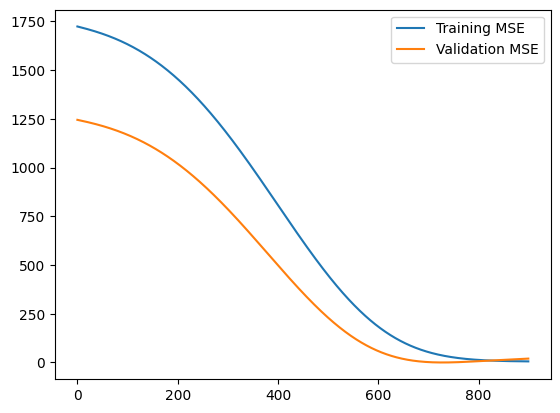

In [22]:
from matplotlib import pyplot as plt

mse_base = history.history['mse']
val_mse_base = history.history['val_mse']
loss_base = history.history['loss']
val_loss_base =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_base,label='Training MSE')
plt.plot(val_mse_base,label='Validation MSE')
plt.legend()
plt.savefig('base_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('base_loss.svg',bbox_inches = 'tight',dpi=600)

In [23]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = model.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 20ms/step
[[40.86536 ]
 [40.437786]]
Root Mean Squared Error: 3.7558661484884266
